In [1]:
# Import library yang diperlukan
!pip install -q pandas sastrawi scikit-learn
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab import files
import re
import nltk
# Download stopwords untuk Bahasa Indonesia
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))
from IPython.display import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 9.2 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
# Load dataset dari file CSV
data = pd.read_csv('/content/chatgpt_reviews_final.csv')
data.head()


,Unnamed: 0,content,score
0,3417,sangat membantu,5
1,1301,Sangat Amat berguna. Ini saya pergunakan untuk...,5
2,3109,Aplikasinya bagus banget !!!,5
3,255,Sebelumnya saya kasih B5 tapi sekarang aku kur...,4
4,277,aplikasi yg sangat sangat bagus dan membantu s...,5


In [30]:
# Hapus baris yang memiliki nilai NaN pada kolom 'content'
data.dropna(axis=0, subset=['content'], inplace=True)

In [31]:


# Inisialisasi stemmer dari Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Upload file positive.tsv dan negative.tsv(lexicon sentimen indo)
uploaded = files.upload()

# Membaca positive dan negative lexicon dari file TSV
positive_lexicon = pd.read_csv('positive.tsv', sep='\t')
negative_lexicon = pd.read_csv('negative.tsv', sep='\t')

# Membuat kamus kata positif dan negatif untuk lookup
positive_dict = dict(zip(positive_lexicon['word'], positive_lexicon['weight']))
negative_dict = dict(zip(negative_lexicon['word'], negative_lexicon['weight']))

# Fungsi untuk menormalisasi kata-kata slang
def normalize_slang(content):
    slang_dict = {
        "gak": "tidak", "gbs": "tidak bisa", "ga": "tidak", "nggak": "tidak",
        "udah": "sudah", "aja": "saja", "mau": "ingin", "gue": "saya",
        "btw": "ngomong-ngomong", "tp": "tapi", "sy": "saya", "anjayyy ": "wow ",
        "ngulang": "mengulang", "yaa": "iya", "njay": " ", "mantaf": "mantap", "fokoknyah": "pokoknya"
    }
    for slang, replacement in slang_dict.items():
        content = re.sub(r'\b' + slang + r'\b', replacement, content)
    return content


Saving negative.tsv to negative (4).tsv
Saving positive.tsv to positive (4).tsv


In [32]:
# Cetak hasil teks sebelum normalisasi slang words
print("Sebelum Normalisasi Slang Words:")
df_content = pd.DataFrame(data['content'].head(10))  # Menampilkan 5 teks pertama sebelum normalisasi
styled_df = df_content.style.set_properties(**{'text-align': 'left'})
display(styled_df)

Sebelum Normalisasi Slang Words:


,content
0,sangat membantu
1,Sangat Amat berguna. Ini saya pergunakan untuk membantu saya untuk mengerjakan soal.
2,Aplikasinya bagus banget !!!
3,"Sebelumnya saya kasih B5 tapi sekarang aku kurangin karena pengalaman tidak menyenangkan, yaitu keresetnya pesan², padahal udah jauh membahas poin A-D eh ngulang lagi ke poin A"
4,"aplikasi yg sangat sangat bagus dan membantu sekali, mantaf lah fokoknyah"
5,Terlalu sempurna
6,masa ngerjain mtk keluarnya pke /frac gbs dibaca njay
7,sangat membantu
8,sangat bermanfaat
9,anjayyy bagus banget apk nya


In [33]:
# Fungsi untuk preprocessing teks (menghapus URL, non-alfabet, normalisasi slang)
def preprocess_content(content):
    content = re.sub(r'http\S+|www\S+|https\S+', '', content, flags=re.MULTILINE)  # Hapus URL
    content = re.sub('[^a-zA-Z0-9\s]', '', content)  # Hapus karakter non-alfabet
    content = content.lower() #Mengubah semua huruf pada content menjadi huruf kecil
    content = normalize_slang(content)  # Normalisasi slang
    return content


In [34]:
# Terapkan normalisasi slang words
data['content'] = data['content'].apply(preprocess_content)

# Cetak hasil teks setelah normalisasi slang words
print("Setelah Normalisasi Slang Words:")
df_content = pd.DataFrame(data['content'].head(10))  # Menampilkan 5 teks pertama sebelum normalisasi
styled_df = df_content.style.set_properties(**{'text-align': 'left'})
display(styled_df)

Setelah Normalisasi Slang Words:


,content
0,sangat membantu
1,sangat amat berguna ini saya pergunakan untuk membantu saya untuk mengerjakan soal
2,aplikasinya bagus banget
3,sebelumnya saya kasih b5 tapi sekarang aku kurangin karena pengalaman tidak menyenangkan yaitu keresetnya pesan padahal sudah jauh membahas poin ad eh mengulang lagi ke poin a
4,aplikasi yg sangat sangat bagus dan membantu sekali mantap lah pokoknya
5,terlalu sempurna
6,masa ngerjain mtk keluarnya pke frac tidak bisa dibaca
7,sangat membantu
8,sangat bermanfaat
9,wow bagus banget apk nya


In [37]:
# Cache untuk kata-kata yang sudah di-stem
stem_cache = {}
# Fungsi untuk preprocessing teks (stemming)
def stem_words(words):
    processed_words = []
    for word in content.split():
        if word in stem_cache:
            processed_words.append(stem_cache[word])  # Ambil dari cache
        else:
            stemmed_word = stemmer.stem(word)  # Stem kata baru
            stem_cache[word] = stemmed_word  # Simpan di cache
            processed_words.append(stemmed_word)

    # Gabungkan kembali hasil preprocessing
    return ' '.join(processed_words)

In [39]:
# Contoh penggunaan
content = "menghilangkan."
preprocessed_content = preprocess_content(content)
stemmed_content = stem_words(preprocessed_content.split())
result = ' '.join(stemmed_content)

print(result)

h i l a n g


In [40]:
# Fungsi untuk mendapatkan label sentimen berdasarkan lexicon
def get_sentiment(content):
    # Melakukan stemming pada konten
    content_stemmed = stemmer.stem(content.lower())  # Stemming konten
                                                     #membuat menjadi huruf kecil semua

    # Inisialisasi skor sentimen
    score = 0

    # Menghitung skor sentimen berdasarkan kata-kata di dalam konten
    for word in content_stemmed.split():
        if word in positive_dict:
            score += positive_dict[word]  # Tambahkan bobot dari kata positif
        elif word in negative_dict:
            score += negative_dict[word]  # Kurangkan bobot dari kata negatif

    # Tentukan label sentimen berdasarkan skor
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [41]:
!pip install swifter
import swifter


# Terapkan preprocessing pada kolom 'content'
data['content'] = data['content'].swifter.apply(preprocess_content)

# Terapkan pelabelan sentimen berdasarkan lexicon ke seluruh dataset
data['sentiment'] = data['content'].apply(get_sentiment)

# Tampilkan beberapa contoh hasil pelabelan sentimen
print(data[['content', 'sentiment']].head())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 16.2 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=d2ae129dcfa1a5e7755c1b46d9edc1fa8ebca0de41a87cb9aae66a5b031ee832
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

                                             content sentiment
0                                       sangat bantu  Positive
1  sangat amat guna ini saya guna untuk bantu say...  Positive
2                              aplikasi bagus banget  Positive
3  belum saya kasih b5 tapi sekarang aku rangin k...  Positive
4  aplikasi yg sangat sangat bagus dan bantu seka...  Positive


In [44]:
# Tampilkan hasil pembagian data berdasarkan sentimen
print(f"Sentimen Positif: {len(data[data['sentiment'] == 'Positive'])}")
print(f"Sentimen Negatif: {len(data[data['sentiment'] == 'Negative'])}")
print(f"Sentimen Netral: {len(data[data['sentiment'] == 'Neutral'])}")

Sentimen Positif: 3926
Sentimen Negatif: 884
Sentimen Netral: 190


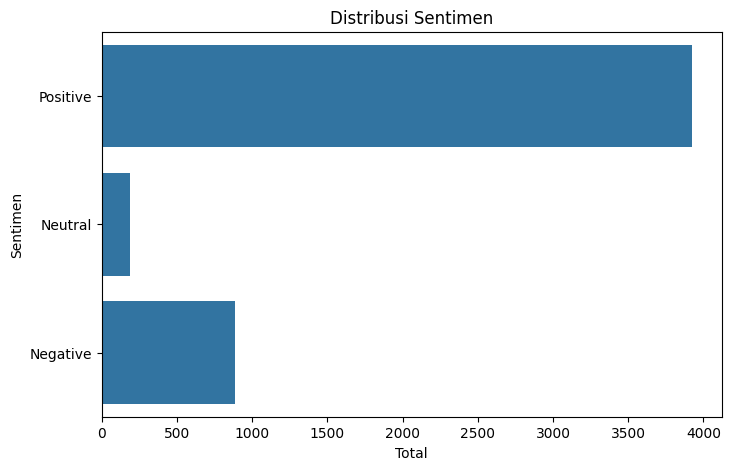

In [45]:
# Visualisasi Sentimen
plt.figure(figsize=(8,5))
sns.countplot(data['sentiment'])
plt.title('Distribusi Sentimen')
plt.xlabel('Total')
plt.ylabel('Sentimen')
plt.show()

In [46]:

# Tokenisasi dan padding untuk data
max_features = 2000  # Jumlah kata unik maksimum
MAX_SEQUENCE_LENGTH = 250  # Panjang maksimal sequence
EMBEDDING_DIM = 100  # Dimensi embedding

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data['content'].values)
X = tokenizer.texts_to_sequences(data['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Encode 'sentiment' (label sentimen yang dihasilkan) sebagai one-hot encoding
y = pd.get_dummies(data['sentiment']).values  # One-hot encoding untuk 3 label sentimen

# Bagi dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4500, 250) (4500, 3)
(500, 250) (500, 3)


In [52]:
print(tokenizer.word_index)


{'sangat': 1, 'bantu': 2, 'dan': 3, 'aplikasi': 4, 'ini': 5, 'bagus': 6, 'saya': 7, 'yang': 8, 'bisa': 9, 'untuk': 10, 'tidak': 11, 'di': 12, 'nya': 13, 'jawab': 14, 'buat': 15, 'dalam': 16, 'banget': 17, 'ada': 18, 'guna': 19, 'baik': 20, 'dengan': 21, 'sekali': 22, 'chatgpt': 23, 'tapi': 24, 'jadi': 25, 'aku': 26, 'ai': 27, 'tanya': 28, 'apk': 29, 'lebih': 30, 'kerja': 31, 'yg': 32, 'lagi': 33, 'tugas': 34, 'sudah': 35, 'ajar': 36, 'chat': 37, 'keren': 38, 'kasih': 39, 'mudah': 40, 'juga': 41, 'kita': 42, 'banyak': 43, 'saja': 44, 'terimakasih': 45, 'suka': 46, 'apa': 47, 'cari': 48, 'dari': 49, 'gpt': 50, 'ingin': 51, 'karena': 52, 'atau': 53, 'informasi': 54, 'tolong': 55, 'beri': 56, 'cepat': 57, 'dapat': 58, 'soal': 59, 'semua': 60, 'saat': 61, 'manfaat': 62, 'kurang': 63, 'mantap': 64, 'itu': 65, 'sama': 66, 'seperti': 67, 'hal': 68, 'moga': 69, 'biasa': 70, 'terima': 71, 'bahasa': 72, 'fitur': 73, 'luar': 74, 'lain': 75, 'tahu': 76, 'masih': 77, 'ya': 78, 'tambah': 79, 'salah':

In [53]:
X = tokenizer.texts_to_sequences(data['content'].values)
print(X[:5])  # Menampilkan 5 urutan pertama


[[1, 2], [1, 430, 19, 5, 7, 19, 10, 2, 7, 10, 31, 59], [4, 6, 17], [108, 7, 39, 1090, 24, 170, 26, 1091, 52, 336, 11, 161, 370, 1863, 297, 105, 35, 248, 411, 844, 513, 773, 188, 33, 101, 844, 703], [4, 32, 1, 1, 6, 3, 2, 22, 64, 140, 106]]


In [54]:
from keras.preprocessing.sequence import pad_sequences
X_padded = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print(X_padded[:5])  # Menampilkan 5 urutan padded pertama


[[  0   0   0 ...   0   1   2]
 [  0   0   0 ...  10  31  59]
 [  0   0   0 ...   4   6  17]
 [  0   0   0 ... 101 844 703]
 [  0   0   0 ...  64 140 106]]


In [56]:
# Menampilkan hasil
print("Hasil tokenisasi:")
df_content = pd.DataFrame(tokenized_df.head(5))  # Menampilkan 5 teks pertama sebelum normalisasi
styled_df = df_content.style.set_properties(**{'text-align': 'left'})
display(styled_df)
 # Menampilkan 5 baris pertama

Hasil tokenisasi:


,Original Text,Tokenized Sequence
0,sangat bantu,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2]"
1,sangat amat guna ini saya guna untuk bantu saya untuk kerja soal,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 430, 19, 5, 7, 19, 10, 2, 7, 10, 31, 59]"
2,aplikasi bagus banget,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 17]"
3,belum saya kasih b5 tapi sekarang aku rangin karena alam tidak senang yaitu keresetnya pesan padahal sudah jauh bahas poin ad eh ulang lagi ke poin a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 108, 7, 39, 1090, 24, 170, 26, 1091, 52, 336, 11, 161, 370, 1863, 297, 105, 35, 248, 411, 844, 513, 773, 188, 33, 101, 844, 703]"
4,aplikasi yg sangat sangat bagus dan bantu sekali mantap lah pokok,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [47]:
# Hasil Pembagian Dataset
print(f"Total data training: {len(X_train)}, Data testing: {len(X_test)}")
print(f"Total data: {len(data)}")


Total data training: 4500, Data testing: 500
Total data: 5000


In [48]:
from keras.callbacks import EarlyStopping
# Bangun model LSTM
model = Sequential()
model.add(Embedding(max_features, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # 3 kelas sentimen: Negatif, Netral, Positif

# Kompilasi model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping untuk menghindari overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# Train model
epochs = 6
batch_size = 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stop])


Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 485ms/step - accuracy: 0.7663 - loss: 0.7264 - val_accuracy: 0.7933 - val_loss: 0.5380
Epoch 2/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 480ms/step - accuracy: 0.7998 - loss: 0.5217 - val_accuracy: 0.8511 - val_loss: 0.3747
Epoch 3/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 471ms/step - accuracy: 0.8803 - loss: 0.3392 - val_accuracy: 0.8711 - val_loss: 0.3315
Epoch 4/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 476ms/step - accuracy: 0.9181 - loss: 0.2404 - val_accuracy: 0.8844 - val_loss: 0.3101
Epoch 5/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 478ms/step - accuracy: 0.9341 - loss: 0.1830 - val_accuracy: 0.8778 - val_loss: 0.3082
Epoch 6/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 489ms/step - accuracy: 0.9457 - loss: 0.1488 - val_accuracy: 0.9000 - val_loss: 0.2989


In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# Evaluasi model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


In [58]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Laporan klasifikasi
class_report = classification_report(y_test_classes, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:")
print(class_report)



Confusion Matrix:
[[ 76   0  12]
 [  6   1   5]
 [ 13   0 387]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.86      0.83        88
     Neutral       1.00      0.08      0.15        12
    Positive       0.96      0.97      0.96       400

    accuracy                           0.93       500
   macro avg       0.92      0.64      0.65       500
weighted avg       0.93      0.93      0.92       500



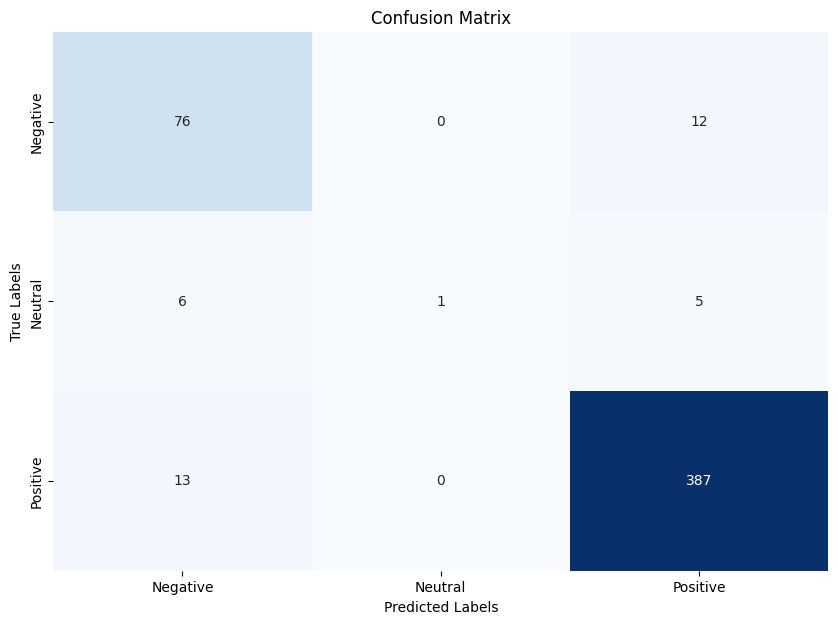

In [59]:
# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix)

In [61]:
# Akurasi model LSTM
lstm_accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

LSTM Accuracy: 0.9280


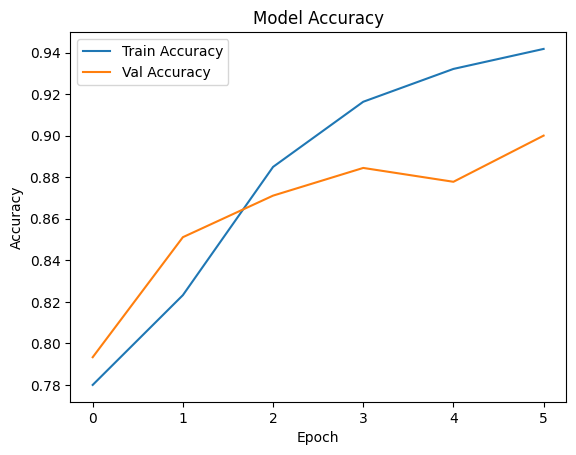

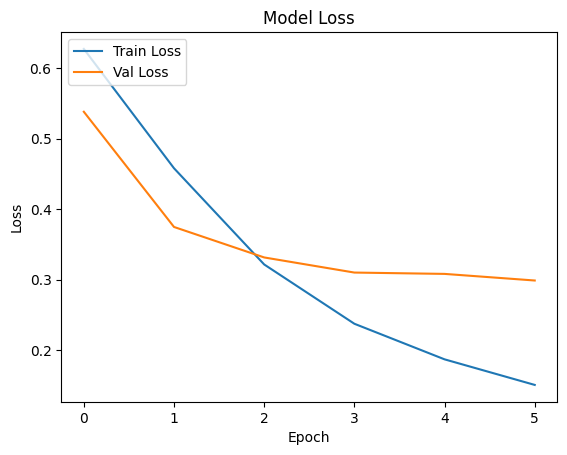

In [62]:
# Plotting akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

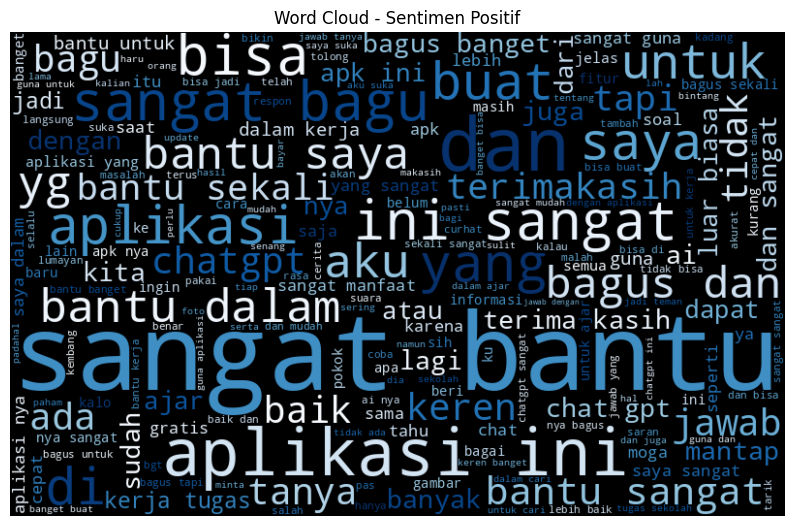

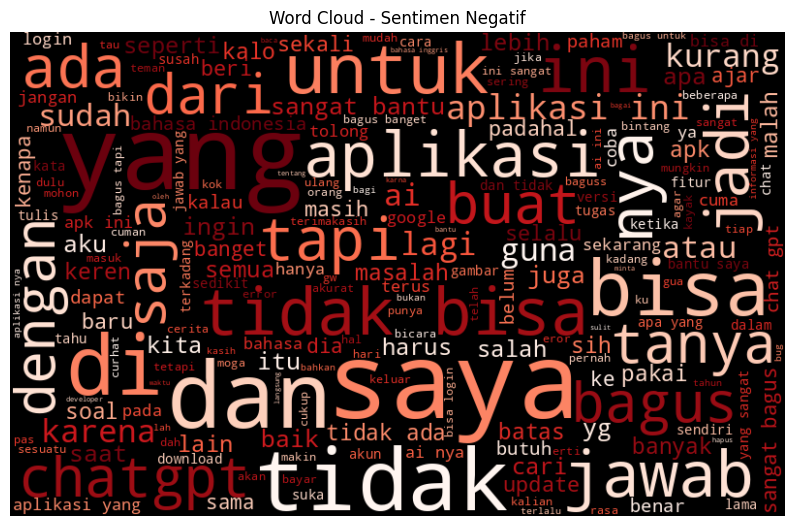

In [76]:
from wordcloud import WordCloud
# Word Cloud untuk Sentimen Positif
positive_words = ' '.join([text for text in data[data['sentiment'] == 'Positive']['content']])
positive_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, colormap='Blues').generate(positive_words)

plt.figure(figsize=(10, 7))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud - Sentimen Positif')
plt.show()

# Word Cloud untuk Sentimen Negatif
negative_words = ' '.join([text for text in data[data['sentiment'] == 'Negative']['content']])
negative_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, colormap='Reds').generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud - Sentimen Negatif')
plt.show()

In [68]:

# Tampilkan 3 contoh dari setiap kategori sentimen
def display_examples(sentiment_label):
    examples = data[data['sentiment'] == sentiment_label].head(5)
    print(f"\nContoh {sentiment_label} Sentiment:")
    for idx, row in examples.iterrows():
        print(f"{idx+1}. {row['content']}")

# Tampilkan contoh untuk sentimen negatif, netral, dan positif
display_examples('Negative')
display_examples('Neutral')
display_examples('Positive')



Contoh Negative Sentiment:
7. masa ngerjain mtk keluar pke frac tidak bisa baca
16. kalau ingin ngirim foto harus bayar fiturr
20. tidak perlu kata kata yang penting chat gpt tetap istimewa
21. gabisa login tulis cek tanggal dan internet
33. kadang jawab nya nyeleneh dan kurang tepatmode suara ke teks nya tidak akurat

Contoh Neutral Sentiment:
6. terlalu sempurna
26. tolong di per banyyak supaya bisa buatlogo
60. puas saya dengan applikasi inj
120. aplikasi keren
156. keren bngat si ini

Contoh Positive Sentiment:
1. sangat bantu
2. sangat amat guna ini saya guna untuk bantu saya untuk kerja soal
3. aplikasi bagus banget
4. belum saya kasih b5 tapi sekarang aku rangin karena alam tidak senang yaitu keresetnya pesan padahal sudah jauh bahas poin ad eh ulang lagi ke poin a
5. aplikasi yg sangat sangat bagus dan bantu sekali mantap lah pokok


In [81]:
# Fungsi untuk memproses kalimat input dan mengembalikan sentimen
def analyze_sentiment(input_text):
    # Preprocessing input text
    preprocessed_text = preprocess_content(input_text)

    # Mendapatkan sentimen dari teks yang sudah diproses
    sentiment = get_sentiment(preprocessed_text)

    return sentiment

# Fungsi untuk meminta input dari pengguna dan menganalisis sentimen
def main():
    print("silahkan mencoba analisis sentimen!")
    print("Masukkan kalimat untuk di analisis sentimen atau ketik '1' untuk selesai):")

    while True:
        user_input = input("\nMasukkan kalimat: ")

        # Memeriksa jika pengguna ingin keluar
        if user_input.lower() == '1':
            print("Terima kasih!")
            break

        # Menampilkan hasil sentimen
        try:
            sentiment_result = analyze_sentiment(user_input)
            print(f"Sentimen kalimat yang Anda masukkan adalah: {sentiment_result}")
        except Exception as e:
            print(f"Terjadi kesalahan: {e}. Mohon coba lagi.")

# Menjalankan fungsi utama
if __name__ == "__main__":
    main()


silahkan mencoba analisis sentimen!
Masukkan kalimat untuk di analisis sentimen atau ketik '1' untuk selesai):

Masukkan kalimat: a
Sentimen kalimat yang Anda masukkan adalah: Neutral

Masukkan kalimat: ap
Sentimen kalimat yang Anda masukkan adalah: Neutral

Masukkan kalimat: 1
Terima kasih!
